In [1]:
import os
import io
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pydot
import graphviz

In [2]:
img_size = 299

以下是問題一所implement的三種residual block
ResBlock_1是ResNet系列模型中residual block的基本型態
ResBlock_2是Inception系列模型上加入Residual block
ResBlock_3是在Residual block上加入Squeeze Excitation Network

In [3]:
def ResBlock_1(inputs, kernel_size, filters, name='Residual_1'):
    filters1, filters2, filters3 = filters #指定各層中filter的數目
    x = layers.Conv2D(filters1,(1,1))(inputs) #第一層卷積層 conv2d 1*1
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters2,kernel_size, padding='same')(inputs) #第二層卷積層 conv2d 3*3，padding="same"避免最後無法add起來
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters3,(1,1))(inputs) #第二層卷積層 conv2d 1*1
    x = layers.BatchNormalization()(x)
    #由於輸入層和經過三層卷積層過後的filter數目可能不同，如果不同加入conv2d 1*1將輸入層filter數目調成一致
    if inputs.shape.as_list()[-1]!=filters3: 
        inputs = layers.Conv2D(filters3,(1,1))(inputs)    
    output = layers.Add()([x,inputs])
    output = layers.Activation('relu')(output)
    return output

def ResBlock_2(inputs, kernel_size, filters, name='Residual_2'):
    filters1, filters2 = filters #指定各層中filter的數目
    x = layers.Conv2D(filters1,(1,1))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    layer21 = layers.Conv2D(filters2,kernel_size,padding='same')(x)
    layer21 = layers.BatchNormalization()(layer21)
    layer21 = layers.Activation('relu')(layer21)
    layer22 = layers.Conv2D(filters2,kernel_size,padding='same')(x)
    layer22 = layers.BatchNormalization()(layer22)
    layer22 = layers.Activation('relu')(layer22)
    layer23 = layers.Conv2D(filters2,kernel_size,padding='same')(x)
    layer23 = layers.BatchNormalization()(layer23)
    layer23 = layers.Activation('relu')(layer23)
    concat = layers.Concatenate()([layer21, layer22, layer23]) #concatenate
    #concatenate之後filter數目會改變，若要建立residual block，輸入層filter數目要調整
    if inputs.shape.as_list()[-1]!=concat.shape.as_list()[-1]: 
        inputs = layers.Conv2D(concat.shape.as_list()[-1],[1,1])(inputs)
    output = layers.Add()([concat,inputs])
    output = layers.Activation('relu')(output)
    return output

def ResBlock_3(inputs, kernel_size, filters, name='Residual_3'):
    filters1, filters2, filters3 = filters
    x = layers.Conv2D(filters1,(1,1))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    layer21 = layers.Conv2D(filters2,(1,1),kernel_regularizer=keras.regularizers.l2(0.001))(x)
    layer21 = layers.BatchNormalization()(layer21)
    layer21 = layers.Activation('relu')(layer21)
    ##layer 23製造squeeze matrix來excite layer22
    ##加入l2 normalization是因為在實作問題二時有嘗試使用ResidualBlock_3來堆疊搭建神經網絡，未避免overfitting才有這樣的設定
    ##因為用ResidualBlock_3搭建的效果不好(見下述)，且ResidualBlock_3使用起來不便利，因此在以下有將Squeeze and excitation
    ##和residual block中的shortcut與卷積層分開來寫見底下的squeeze_excitation_layer和conv_block函式
    layer22 = layers.Conv2D(filters2,kernel_size, padding='same',kernel_regularizer=keras.regularizers.l2(0.001))(x)
    layer22 = layers.BatchNormalization()(layer22)
    layer22 = layers.Activation('relu')(layer22)
    layer23 = layers.Conv2D(filters2,kernel_size,padding='same',kernel_regularizer=keras.regularizers.l2(0.001))(x)
    layer23 = layers.BatchNormalization()(layer23)
    layer23 = layers.Activation('relu')(layer23)
    layer23 = layers.GlobalAveragePooling2D()(layer23)
    layer23 = layers.Reshape((1,1,filters2))(layer23)
    layer23 = layers.Dense(filters2, activation="sigmoid",kernel_regularizer=keras.regularizers.l2(0.001))(layer23)
    se = layers.multiply([layer22, layer23])
    se = layers.Conv2D(filters3,1,kernel_regularizer=keras.regularizers.l2(0.001))(se)
    sea = layers.Activation('relu')(se)
    concat = layers.Concatenate()([layer21, sea])
    concat = layers.Conv2D(filters3,3, padding='same',kernel_regularizer=keras.regularizers.l2(0.001))(concat)
    if inputs.shape.as_list()[-1]!=filters3:
        inputs = layers.Conv2D(filters3,(1,1),kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
    output = layers.Add()([concat,inputs, se])
    output = layers.Activation('relu')(output)
    return output



In [4]:
import os
# load dataset
dataset_dir = './food11'
# create new dir
try:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    for i in range(11):
        os.mkdir(f'train/{i:02d}')
        os.mkdir(f'valid/{i:02d}')
except:
    pass

In [5]:
for sub_dir in ['training', 'validation', 'test']:
    target_dir = os.path.join(dataset_dir, sub_dir)
    img_list = os.listdir(target_dir)
    for img_name in img_list:
        category, *r = img_name.split('_')
        img_path = os.path.join(target_dir, img_name)
        if len(r) == 0:
            new_fn = f'{sub_dir}/{img_name}'
        else:
            category = int(category)
            new_fn = f'{sub_dir[:5]}/{category:02d}/{img_name}'
    # resize image
        os.rename(img_path, new_fn)

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True) #image augmentation
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(299, 299),
        batch_size=20,
        class_mode='sparse')
validation_generator = test_datagen.flow_from_directory(
        'valid',
        target_size=(299, 299),
        batch_size=20, #因應本機端gpu memory不足，batch size設20
        class_mode='sparse')

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


我有嘗試使用ResidualBlock_1, ResidualBlock_3去建立神經網絡
大概接到第八到第九個block就開始出現overfitting的情形，有嘗試過在residual block隱藏層中加入l2 normalization
或在residual block間加上dropout進行處理，但成效還是不佳，validation data的accuracy仍然波動很大，大概在batch size=64的設定下，
在epoch至50時達到最大值，之後開始逐漸遞減，overfitting很嚴重，整體來說，自己嘗試的模型，accuracy最多只到0.5~0.6
另外儘管是residual block的架構，串太多層也會有退化，另外由於樣本不是很大(train的樣本大概9000)，很多圖形的特徵在這樣的樣本數下或許很難
chracterize出來，因此針對問題二的部分，我引入inception v3的pre-trained model進行遷移學習，
在mixed8 layer(即下圖第八個紅色Concat層)，之後再加入卷積層和residual block，最後再使用Global Average Pooling取代全連接層，根
據一些研究分析，Global Average Pooling有比較低的訓練損失。

In [67]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://production-media.paperswithcode.com/methods/inceptionv3onc--oview_vjAbOfw.png")

In [69]:
Image(url="https://adventuresinmachinelearning.com/wp-content/uploads/2019/05/Global-average-pooling-accuracy.png")

In [7]:
## 隱藏層採用he normal initialization避免潛在梯度爆炸的風險
def squeeze_excitation_layer(input_layer, out_dim, ratio, conv):
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_layer)
    excitation = tf.keras.layers.Dense(units=out_dim / ratio, activation='relu')(squeeze)
    excitation = tf.keras.layers.Dense(out_dim,activation='sigmoid')(excitation)
    excitation = tf.reshape(excitation, [-1,1,1,out_dim])
    scale = tf.keras.layers.multiply([input_layer, excitation])
    if conv:
        shortcut = tf.keras.layers.Conv2D(out_dim, kernel_size=1, strides=1, padding='same',kernel_initializer='he_normal')(input_layer)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    else:
        shortcut = input_layer
    out = tf.keras.layers.add([shortcut, scale])
    return out

def conv_block(input_layer,filters):
    layer = tf.keras.layers.Conv2D(filters,kernel_size=1,strides=1, padding='same',kernel_initializer='he_normal', use_bias=False)(input_layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.Conv2D(filters,kernel_size=3,strides=1, padding='same',kernel_initializer='he_normal', use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.Conv2D(filters*4,kernel_size=1,strides=1, padding='same',kernel_initializer='he_normal', use_bias=False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    return layer

from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape=(299,299,3), include_top = False, weights = 'imagenet')
last_layer = pre_trained_model.get_layer('mixed8') #引入mixed8以前InceptionV3的layer和權重 
last_output = last_layer.output #在mixed8之後接上卷積層
x = tf.keras.layers.Conv2D(64,kernel_size=3,strides=1, padding='same',kernel_initializer='he_normal', use_bias=False)(last_output)
x = tf.keras.layers.BatchNormalization()(x) #Batch Normalization
x = tf.keras.layers.ReLU()(x)
x =  tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
x = layers.Dropout(0.3)(x) #避免overfitting
x = conv_block(x,64) #開始疊第一個residual block
x = squeeze_excitation_layer(x, out_dim=256, ratio=32.0, conv=True) #完成第一個residual block的堆疊
x = layers.Dropout(0.3)(x) #避免overfitting
x = conv_block(x,128) #開始疊第二個residual block
x = squeeze_excitation_layer(x, out_dim=512, ratio=32.0, conv=True) #完成第二個residual block的堆疊
x = layers.Dropout(0.3)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x) #取代全連接層
x = layers.Dropout(0.3)(x)
model_output = tf.keras.layers.Dense(11, activation='softmax')(x) #輸出層
model = tf.keras.models.Model(pre_trained_model.input,model_output)
model.summary()

##調整學習率，採用學習率隨epoch數上升呈遞減的狀態，避免一開始學習過慢，之後overshooting的情形
starter_learning_rate = 1e-2
end_learning_rate = 1e-3
decay_steps = 3000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(starter_learning_rate, decay_steps, end_learning_rate, power=0.6, cycle=True)
model_dir='labexam-logs/models'
os.makedirs(model_dir)
log_dir = os.path.join('exam','model')
model_cbk=keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp=keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-exam.h5', monitor='val_sparse_categorical_accuracy',save_best_only=True,mode='max')
model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[keras.metrics.SparseCategoricalAccuracy()])
##這個週末第一天都在嘗試自己建立神經網絡模型，但效果不佳，準確率只有0.5-0.6，週日中午改用遷移學習，準確率提升到0.91-0.92
history_1=model.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=[model_cbk,model_mckp])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

C:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/30
494/494 [==============================] - 223s 429ms/step - loss: 1.2618 - sparse_categorical_accuracy: 0.5836 - val_loss: 0.7796 - val_sparse_categorical_accuracy: 0.7475
Epoch 2/30
494/494 [==============================] - 208s 421ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.7969 - val_loss: 0.5709 - val_sparse_categorical_accuracy: 0.8146
Epoch 3/30
494/494 [==============================] - 208s 420ms/step - loss: 0.4621 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4501 - val_sparse_categorical_accuracy: 0.8641
Epoch 4/30
494/494 [==============================] - 208s 420ms/step - loss: 0.3627 - sparse_categorical_accuracy: 0.8876 - val_loss: 0.4619 - val_sparse_categorical_accuracy: 0.8563
Epoch 5/30
494/494 [==============================] - 208s 420ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.4233 - val_sparse_categorical_accuracy: 0.8813
Epoch 6/30
494/494 [==============================] - 208s 420ms/step - loss: 0.

In [58]:
##讀取test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    image_size=(299, 299),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)

Found 3347 files belonging to 1 classes.


In [62]:
test_set = test_set.map(lambda x: (tf.divide(x, 255))) #對test_set進行rescaling


In [63]:
##將預測結果輸出為csv檔
model.load_weights('labexam-logs/models/Best-model-exam.h5')
answer = model.predict(test_set)
df = pd.DataFrame()
df["Id"] = ["0"*(4-len(str(i)))+str(i) for i in range(1,np.shape(answer)[0]+1)]
def get_class(i):
    top_1_index = np.argsort(answer[i])[10]
    return top_1_index 
df["Category"] = [get_class(i) for i in range(0,np.shape(answer)[0])]
df.to_csv("submission.csv",index = False)



下圖為模型prediction結果

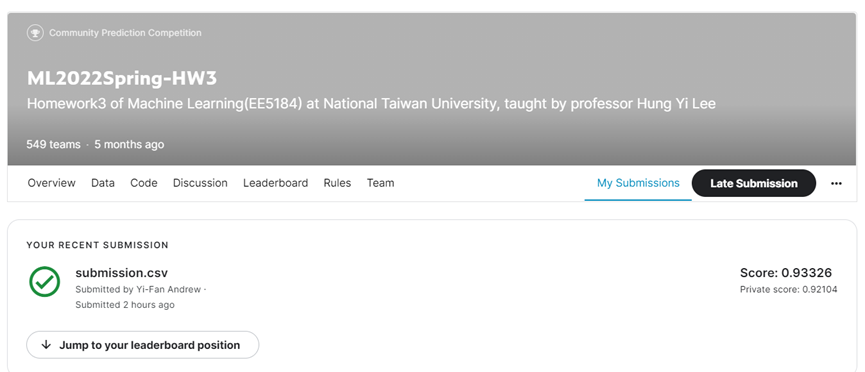

上面主要比較像是在對模型進行fine tuning，移除較高層的卷積層或inception block，之後加入一部分residual block，但這勢必面臨trade off，因為本測驗使用的資料樣本數比inception v3在training時的樣本小很多，inception v3是使用imagenet進行訓練，test data有1281167，分類有1000種，而本測驗樣本數只有9000，雖然可能本測驗的分類物件與inception v3訓練時的資料可能有很大不同，但fine tuning比直接加上全連接層或global average pooling更可能面臨過擬合的問題，因此以上純屬fine tune的實作，但fine tuning在這資料上不一定會比純粹加上全連接層或global average pooling來得好。